In [126]:
import pandas as pd
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
import csv

In [127]:
### Obtener datos 
p = pd.read_csv("../datos/datos_originales/vih_descarga/02_analisis_datos/paciente_cluster.csv")
c = pd.read_csv("../datos/datos_originales/vih_descarga/02_analisis_datos/vih_clusters.csv")
r = pd.read_csv("../datos/datos_originales/vih_descarga/02_analisis_datos/vih_red_completa.csv")

In [128]:
# Unimos las bases descargadas para obtener los id de participantes en clusters, la distancia entre cada miembro del cluster y su resistencia 
datos_grafo = pd.merge(left = c, right = p[['cluster_id', 'id_muestra']], how='right', left_on='id1', right_on='id_muestra')
datos_grafo = pd.merge(left = datos_grafo, right = r[['resistencia', 'id_muestra']], how='right', left_on='id1', right_on='id_muestra')
datos_grafo = datos_grafo.loc[datos_grafo['id1'].notnull()].drop(['id_muestra_x', 'id_muestra_y'], axis=1)
datos_grafo['distancia'] = datos_grafo['distancia'].round(1)

In [129]:
# Añadimos el rango de distancia genética 
def rango(valor):
    if 0 <= valor < 0.5:
        return '0 a 0.5'
    elif 0.5 <= valor < 1:
        return '0.5 a 1'
    elif 1<= valor <= 1.5:
        return '1 a 1.5'
    else:
        return 'Fuera de rango'

datos_grafo['distancia_rango'] = datos_grafo['distancia'].apply(rango)

In [130]:
datos_grafo.head() 

,id1,id2,distancia,grado,cluster_id,resistencia,distancia_rango
1,CEC-19-0002,CEC-21-5196,0.7,2.0,534.0,Sin resistencia,0.5 a 1
2,CEC-19-0002,CEC-22-7757,0.8,2.0,534.0,Sin resistencia,0.5 a 1
3,CEC-19-0003,CEC-20-0445,1.5,1.0,179.0,Sin resistencia,1 a 1.5
5,CEC-19-0005,CEC-20-0347,0.4,4.0,377.0,NNRTI,0 a 0.5
6,CEC-19-0005,CEC-21-2513,0.3,4.0,377.0,NNRTI,0 a 0.5


In [131]:
# Filtramos los datos del cluster 357 como ejemplo
datos = datos_grafo[datos_grafo['cluster_id'] == 357]
datos.to_csv(os.path.join('..', 'datos', 'datos_procesados', 'c357.csv'))


In [132]:
# Convertir la base de datos del conglomerado 
nombre_archivo = os.path.join('..','datos', 'datos_procesados', 'c357.csv')
with open(nombre_archivo, newline='') as csvfile:
    leer = csv.DictReader(csvfile)
    c357 = [row for row in leer]

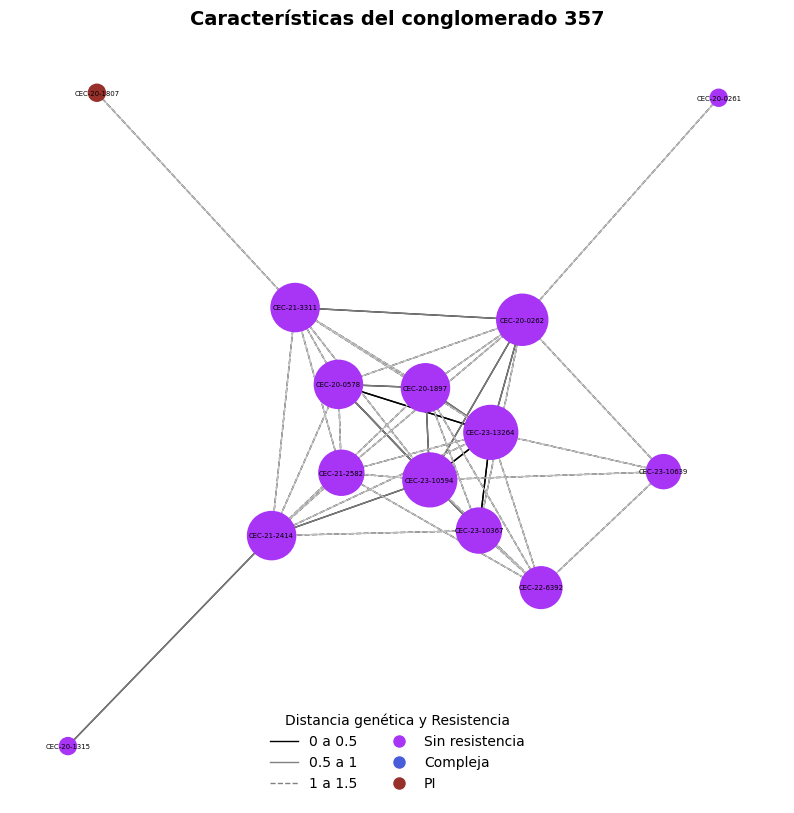

In [134]:
# Crear grafo vacío
G = nx.Graph()

# Añadir aristas al grafo con atributos
for fila in c357:
    G.add_edge(fila['id1'], fila['id2'], distancia=fila['distancia'], distancia_rango=fila['distancia_rango'])

    # Añade o actualiza el atributo 'resistencia' para cada nodo
    if 'resistencia' in G.nodes[fila['id1']]:
        G.nodes[fila['id1']]['resistencia'] += fila['resistencia']
    else:
        G.nodes[fila['id1']]['resistencia'] = fila['resistencia']

    if 'resistencia' in G.nodes[fila['id2']]:
        G.nodes[fila['id2']]['resistencia'] += fila['resistencia']
    else:
        G.nodes[fila['id2']]['resistencia'] = fila['resistencia']

# Definir estilo de las aristas
estilos_aristas = {
    '0 a 0.5': 'solid',
    '0.5 a 1': 'solid',
    '1 a 1.5': 'dashed'
}

# Definir el color de las aristas según 'distancia_rango'
colores_aristas = {
    '0 a 0.5': '#000000', 
    '0.5 a 1': '#7D7D7D', 
    '1 a 1.5': '#C0C0C0'
}

# Definir color de los nodos
def obtener_color(resistencia):
    if resistencia == 'Compleja':
        return '#495CD9'
    elif resistencia == 'PI':
        return '#97302B'
    else:
        return '#A834F6'
    
# Definir tamaño de nodo de acuerdo al "grado"
grados= dict(G.degree())
tamano_base = 150
tamano_nodo = [tamano_base * grados[nodo] for nodo in G.nodes]

# Definir posicion de los nodos     
pos = nx.spring_layout(G, seed=42)

# Crear figura
plt.figure(figsize=(10, 10))

# Asignar estilo de las aristas 
for distancia_rango, estilo in estilos_aristas.items():
    aristas = [(u, v) for u, v, d in G.edges(data=True) if d['distancia_rango'] == distancia_rango]
    nx.draw_networkx_edges(G, pos, edgelist=aristas, style=estilo)

# Asignar color de las aristas
for distancia_rango, color in colores_aristas.items():
    aristas = [(u, v) for u, v, d in G.edges(data=True) if d['distancia_rango'] == distancia_rango]
    nx.draw_networkx_edges(G, pos, edgelist=aristas, edge_color=color)

# Asignar colores a las aristas 
edge_color_list = [colores_aristas[G[u][v]['distancia_rango']] for u, v in G.edges()]

# Asignar color de los nodos 
colores_nodos = [obtener_color(G.nodes[n]['resistencia']) for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=colores_nodos, node_size=tamano_nodo)

# Dibular los nodos 
nx.draw_networkx_labels(G, pos, font_size=5, font_color='black')

# Crear representaciones de las aristas para la leyenda
leyenda_aristas = [
    Line2D([0], [0], color='black', lw=1, label='0 a 0.5'),
    Line2D([0], [0], color='gray', lw=1, label='0.5 a 1'), 
    Line2D([0], [0], color='gray', lw=1, linestyle='dashed', label='1 a 1.5')
]

# Crear representaciones de los nodos para la leyenda
leyenda_nodos = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#A834F6', markersize=10, label= 'Sin resistencia'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#495CD9', markersize=10, label='Compleja'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#97302B', markersize=10, label='PI')
]

# Agregar la leyenda al gráfico
plt.legend(title = "Distancia genética y Resistencia", handles=leyenda_aristas + leyenda_nodos, loc="lower center", fontsize=10, frameon = False, ncol = 2)

plt.title("Características del conglomerado 357", fontsize = 14, weight = "bold")
plt.axis('off')
plt.show()